# Анализ товарного ассортимента

Представлены данные по товарному ассортименту, анализируются на предмет объема продаж исходя из еженедельной активности, в том числе по отдельным товарным группам.

In [1]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
m = Mystem() 
import matplotlib.pyplot as plt
import math as mth
import seaborn as sns
import pylab
from plotly import graph_objects as go
from scipy import stats as st
from scipy.stats import chisquare
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('https://code.s3.yandex.net/datasets/ecommerce_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [4]:
df.head(5)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Колонки в  ecommerce_dataset.csv :
- date — дата заказа;
- customer_id — идентификатор покупателя;
- order_id — идентификатор заказа;
- product — наименование товара;
- quantity — количество товара в заказе;
- price — цена товара.

In [5]:
df.isnull().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

In [6]:
df.duplicated().sum()

0

Нули и дубликаты отсутствуют

Добавим столбец с итоговой суммой

In [7]:
df['order_sum']=df['price']*df['quantity']

In [8]:
# выделим столбец с конкретной датой
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df['hour'] = df['date'].dt.hour
df['week'] = df['date'].dt.day_name()

In [9]:
df['month'] = df['date'].dt.month_name()
df['year'] = df['date'].dt.year

In [10]:
first_date=df['date'].min()
first_date

Timestamp('2018-10-01 00:00:00')

In [11]:
last_date=df['date'].max()
last_date

Timestamp('2019-10-31 16:00:00')

В нашем фрейме данные с 1 октября 18 года до 31 октября 19 года

In [12]:
# выделим сезоны
def season (row):
    months = row['month']
    if months == 'December' or months == 'January' or months == 'February':
        return 'зима'
    if months == 'March' or months == 'April' or months == 'May':
        return 'весна'
    if months == 'June' or months == 'July' or months == 'August':
        return 'лето'   
    else:
        return 'осень'

In [13]:
df['season'] = df.apply(season, axis=1)

In [15]:
df['product']=df['product'].str.lower()

Необходимо выделить товарный ассортимент, для этого проведем лемматизацию

In [18]:
def lemma_pur(product):
    lemma = ' '.join(m.lemmatize(product))
    return lemma

In [19]:
df['product_new'] = df['product'].apply(lemma_pur)
df['product_new']

0       комнатный   растение   в   горшок   алый   вер...
1       комнатный   растение   в   горшок   кофе   ара...
2               радермахер   d - 12   см   h - 20   см \n
3             хризолидокарпус   лутесценс   d - 9   см \n
4          циперус   зумул   d - 12   см   h - 25   см \n
                              ...                        
6732    таз   пластмассовый   40 , 0   л   пищевой   о...
6733    сумка - тележка   2 - х   колесный   gimi   ar...
6734    герань   домашний  ( пеларгония   зональный ) ...
6735    таз   пластмассовый   со   стиральный   доска ...
6736    сумка - тележка   2 - х   колесный   gimi   ar...
Name: product_new, Length: 6737, dtype: object

In [20]:
word_list=df['product_new'].unique().tolist()

In [21]:
import nltk
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
print(lemmatized_output)

комнатный   растение   в   горшок   алый   вера ,  d12 ,  h30 
 комнатный   растение   в   горшок   кофе   арабика ,  d12 ,  h25 
 радермахер   d - 12   см   h - 20   см 
 хризолидокарпус   лутесценс   d - 9   см 
 циперус   зумул   d - 12   см   h - 25   см 
 шеффлер   лузеан   d - 9   см 
 юкка   нитчатый   d - 12   см   h - 25 - 35   см 
 настенный   сушилка   для   белье   gimi   brio   super   100 
 таз   пластмассовый   21 , 0   л   круглый  " водолей "  с614 ,  1404056 
 чехол   для   гладильный   доска   colombo   persia   beige   130х50   см   из   хлопок   5379 
 вешалка   для   брюки   металлический   с   резиновый   покрытие   26   см   цвет :  синий ,  attribute ,  ahs331 
 сушилка   для   белье   потолочный   zalger   lift   basic   1520   200   см ,  10   м 
 чехол   eurogold   clean   basic   хлопок   для   доска   120х38 - 120х42   см   c42 
 крючок   одежный   2 - х   рожковый   серый   металлик   с   полимерный   покрытие  * тонар *,  1110027 
 корзина   мягкий   пла

Соберем по категориям

In [22]:
from collections import defaultdict
product_category=defaultdict(list)
product_category \
= {'растения':['растение','пеларгония','пахира','зверобой','эхинокактус','каландив','клен','огурец','дыня','томат','бакоп','дендробиум','земляника','незабудка','базилик','горох','пуансеттия','крокус','калибрахоа','бальзамин','тюльпан','аптение','ель','кипарисовик','пуансетия','подсолнечник','бальзамин','фаленопсис','диффенбахий','гвоздик','зев','алиссум','календула','косметь','бархатцы','петуния','огурец','морковь','мимоза','косметь','соланум','капсикум','каллун','калоцефалус','дендробиум','каланхое','примула','альбук','лаванда',\
               'бегония','папоротник','флокс','скиммия','лапчатка','розмарин','антуриум ','фиалка','молодило','душица','мелисса','роза','гортензия','пеларгония',\
               'радермахер','лилейник','косметь','овсянница','чабер','декабрист','калла','укроп','тимьян','дендробиум','фикус','аспарагус','крассула','годеция','кориандр','адиантум', 'лутесценс','нолина','калатея','афеляндра','аспарагус','сантолина','иссоп',\
               'эвкалипт','калибрахоа','колокольчик','эхеверие','эхинокактус','спатифиллум','пуансеттия','хлорофитум', 'циперус', 'шеффлер','глоксиния','азалия','гербера','фиалка', 'юкка','цикламен',\
               'рассада','хризантема', 'герань', 'пеларгония', 'суккулент', 'эхеверие'],'хозтовары':['сушилка','скребок','окномойка','ведро','вантуз','мыльница','глажение','рассекатель','шило','термометр','сменный','совок','противоскользящий','пробка','сидение','хранение', ' мыло','таз','мусорный','подголовник','швабра','кумган','мусор', 'чехол', 'вешалка','плечики','крючок', 'корзина', 'щетка','резиновый', 'ерш', 'котел', 'прищепок', 'придверный','дозатор','тележка','гладильный','туалетный'],\
  'посуда':['сковорода','соковарка','сито','скалка','просеиватель','кастрюля','блюдце','завтрак','farandole','дуршлаг','термостакан','чеснок','холодец','хлебница','миска','кекс','бокал','мантоварка','овощечистка','салфетница','стакан','лопатка','фужер','luminarc',' глазунья ','салатник','кондитерский','картофелемялка','масленка','кувшин','выпечка','банка','противень', 'тарелка','свисток','карниз', 'вилка', 'кружка', 'ложка','толкушка', 'нож'],
  'декор':['муляж','фоторамка','терка','офелия','ванный', 'bacchetta', 'интерьерный','искусственный'], \
   'текстиль':['плед','одеяло','наволочка','простыня','белье','покрывало','халат','махровый','наматрасник','полотенце', 'штора','подушка','салфетка','скатерть','хлопковый','простыня'],\
   'строительство-ремонт':['лестница','полка','комод','черенок','скоба','кофр','стрела','угольник','урна','сварка','стеллажный','гаражный','стремянка','стяжка','пружина','крепеж'],\
   'техника-инструменты':['светильник','соковыжималка','штангенциркуль','пылесос','свч',' миксер','электроштопор','инструмент','электронный','фен','электрический','овощеварка','утюг','свереть','сверло','веник'],\
  'бытовая химия':['удаление','отбеливатель','стирка','десна','антинакипин','концентрат','увлажнять','аквилегия','гипоаллергенный','кондиционер','бензин','мыло',' антижир','хлор','известковый','бальзам','ecomatic','ополаскиватель']}

In [23]:
def category(name):
    for key, value in product_category.items():
        for word in value:
            if name.find(word)> -1:
                return key
    return '1001 мелочь'       

In [24]:
df['category']=df['product'].apply(category)

In [25]:
df['category'].value_counts(ascending=False)

растения                4077
хозтовары                933
1001 мелочь              812
посуда                   296
декор                    289
текстиль                 149
строительство-ремонт     118
техника-инструменты       47
бытовая химия             16
Name: category, dtype: int64

Ассортимент магазина представляет собой большое колличество растений-свыше 4000 наименований, далее по убыванию следует-хозтовары, бытовые мелочи, посуда, декор..

In [26]:
df.describe()

,order_id,quantity,price,order_sum,hour,year
count,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000
mean,43128.948345,2.501559,462.028499,720.094998,13.863589,2018.788927
std,27899.414662,15.266478,871.296064,8352.100591,4.969169,0.408100
min,12624.000000,1.000000,9.000000,9.000000,0.000000,2018.000000
25%,14827.000000,1.000000,101.000000,120.000000,10.000000,2019.000000
50%,68503.000000,1.000000,135.000000,162.000000,14.000000,2019.000000
75%,70504.000000,1.000000,398.000000,600.000000,18.000000,2019.000000
max,73164.000000,1000.000000,14917.000000,675000.000000,23.000000,2019.000000


в столбце итоговой суммы есть максимум 675000-его возьмем за выброс и уберем, чистить по другим столбцам нет смысла

In [27]:
df.groupby(['year','month']).agg({'order_id': 'nunique'}).reset_index()

,year,month,order_id
0,2018,December,286
1,2018,November,205
2,2018,October,239
3,2019,April,269
4,2019,August,176
5,2019,February,290
6,2019,January,171
7,2019,July,199
8,2019,June,166
9,2019,March,250


In [28]:
df_clean=df.query('order_sum < 675000')
df1=df_clean.groupby(['year','month']).agg({'order_id': 'nunique'}).reset_index()
df1

,year,month,order_id
0,2018,December,286
1,2018,November,205
2,2018,October,239
3,2019,April,269
4,2019,August,176
5,2019,February,290
6,2019,January,171
7,2019,July,199
8,2019,June,165
9,2019,March,250


потеряли только один очень крутой заказ

##### Посмотрим на распределение выручки по сезонам

In [29]:
top_season = df_clean.groupby('season')['order_sum'].sum().to_frame('order_sum').sort_values(by='order_sum', ascending=False)
top_season

,order_sum
season,
осень,1248599.0
зима,1032943.0
весна,1008677.0
лето,886061.0


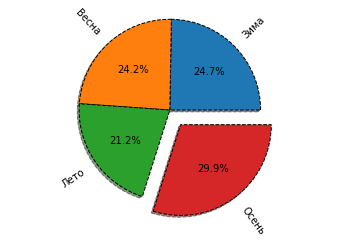

In [30]:
vals = [1032943, 1008677,886061,1248599]
labels = ["Зима", "Весна","Лето","Осень"]
explode = (0, 0, 0, 0.2)
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode,\
       wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
ax.axis("equal");

Распределение выручки имеет несущественное отклонение в пределах 5-10%. При этом осенью отмечен более высокий спрос нежели летом, что обусловлено снижением покупательской активности в целом, из-за сезона отпусков.

<div class="alert alert-success"> скорее тут дело в том, что у нас в данных два октября: 2018 и 2019. Это осенний месяц. А в других сезонах данные только по одному году. </div>

In [29]:
df2=df_clean.groupby(['year','month']).agg({'order_sum': 'sum'}).reset_index()
df2

,year,month,order_sum
0,2018,December,402768.0
1,2018,November,371180.0
2,2018,October,420754.0
3,2019,April,381915.0
4,2019,August,197833.0
5,2019,February,345454.0
6,2019,January,284721.0
7,2019,July,276547.0
8,2019,June,411681.0
9,2019,March,320018.0


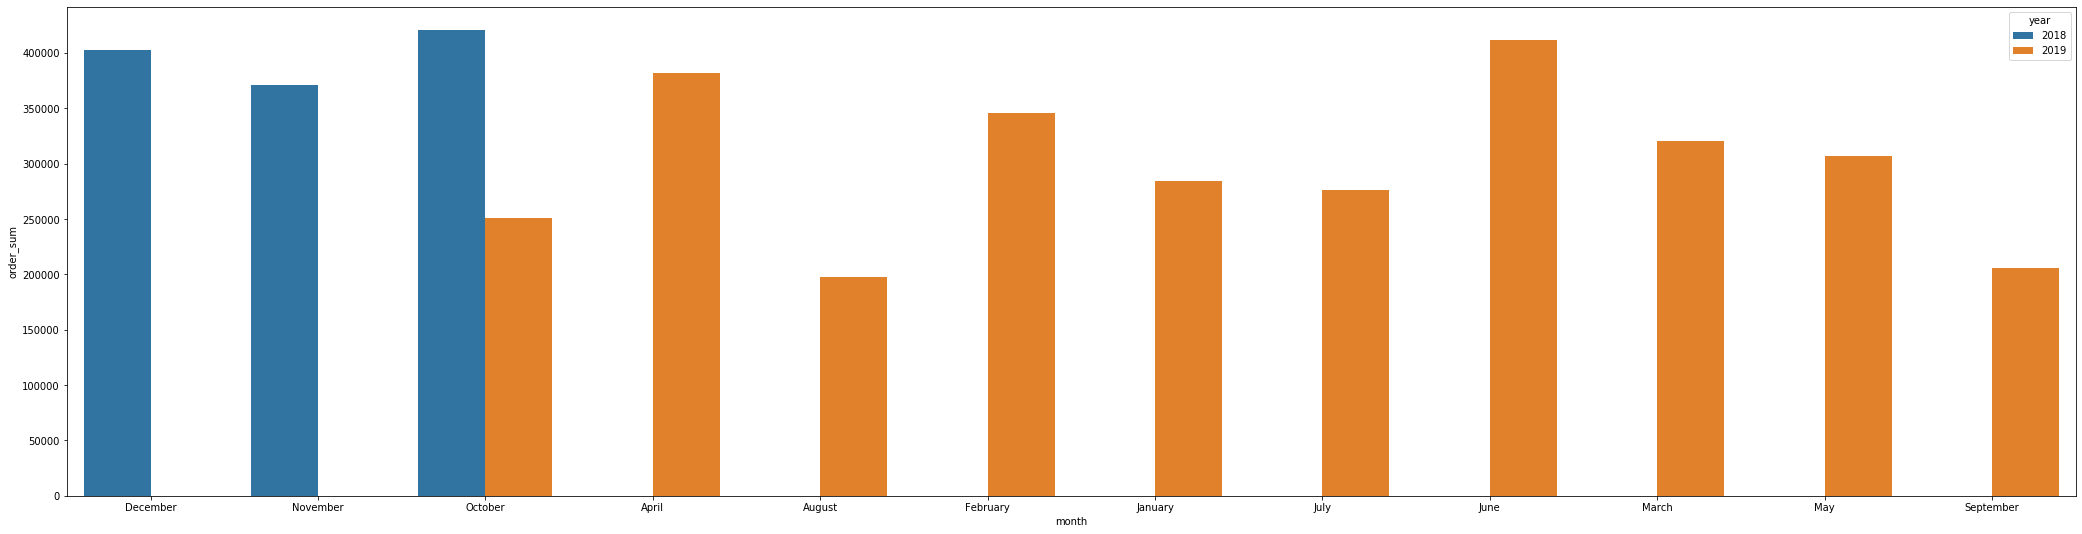

In [30]:
plt.figure(figsize=(36, 9))
ax = sns.barplot(x = "month", y="order_sum",hue="year", data=df2)
plt.title='total sum'
ax.set_xlabel='month'
ax.set_ylabel='order_sum'
plt.show()

По сравнению с октябрем 2018 года, в 2019 году отмечен спад, что возможно объясняется интерфейсом интернет-магазина. Также отмечено увеличение выручки в апреле июне, что объясняется естественной подготовкой потребителей к летнему дачному сезону.

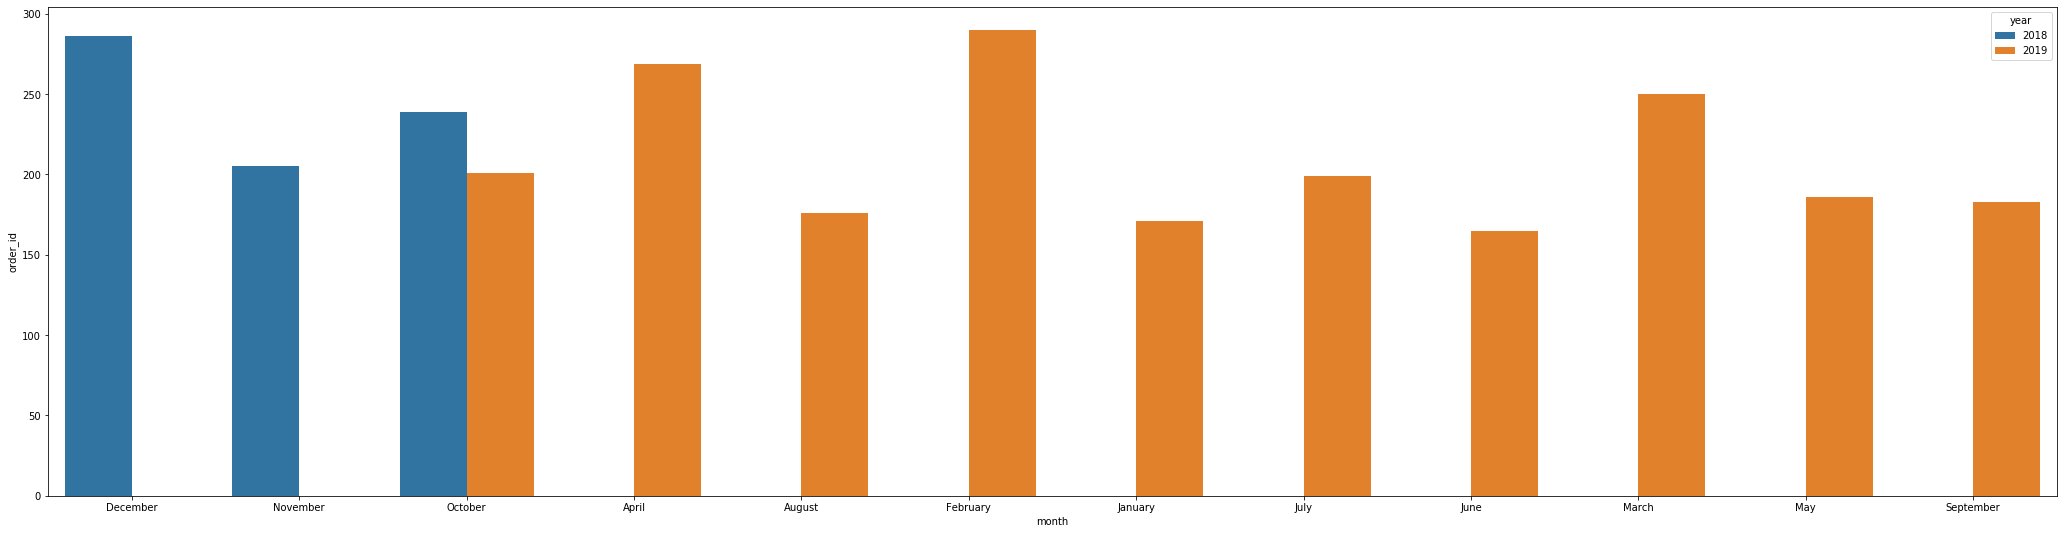

In [31]:
plt.figure(figsize=(36, 9))
ax = sns.barplot(x = "month", y="order_id",hue="year", data=df1)
plt.title='orders'
ax.set_xlabel='month'
ax.set_ylabel='order_id'
plt.show()

Колличество совершенных покупок в декабре, феврале, марте и апреле в среднем выше чем в другие месяцы года. Возможно в виду того, что эти месяца богаты на праздничные события.

In [32]:
top_week = df_clean.groupby('week')['order_sum'].sum().to_frame('order_sum')
top_week

,order_sum
week,
Friday,609777.0
Monday,715083.0
Saturday,331520.0
Sunday,439928.0
Thursday,669256.0
Tuesday,797670.0
Wednesday,613046.0


In [33]:
def make_box_by_category(value=None, category=None, data=None, sort=False, sort_by_column=None, title=None):
    """
    value: боксплоты для каких значений строить
    category: группирующая переменная
    data: данные
    sort: как сортровать
    sort_by_column - по какому полю сортировать (либо то что в value, либо то что в category)
    """
    #сортировка по медиане
    tmp = \
        data\
        .groupby(category, as_index=False)\
        .agg({value:'median'})\
        .sort_values(by=sort_by_column, ascending=sort).reset_index()

    plt.figure(figsize=(9,6))
    sns.boxplot(x=category, y= value, data=data, showfliers=False, order=tmp[category].to_list(), 
                showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
    plt.title='title'
    plt.grid(True)
    plt.show()

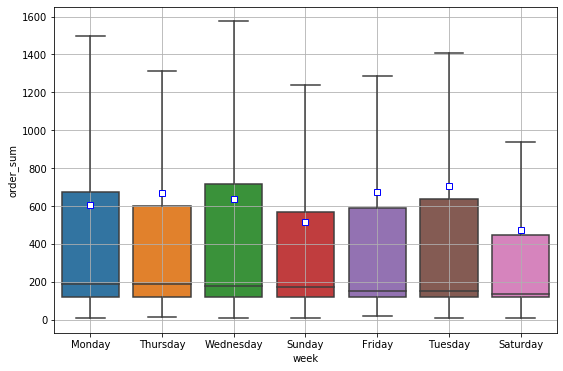

In [34]:
make_box_by_category(value='order_sum', category='week', data=df_clean, sort=False, sort_by_column='order_sum', \
                     title='Распределение прибыли по дням недели')

Исходя из суммы выручки по каждому дню недели, стоит отметить, что суббота, воскресенье и понедельник имеют значительное снижение выручки, потому что покупатели в выходные дни предпоситают загородные дачи и отдых от интрнета и шопинга.

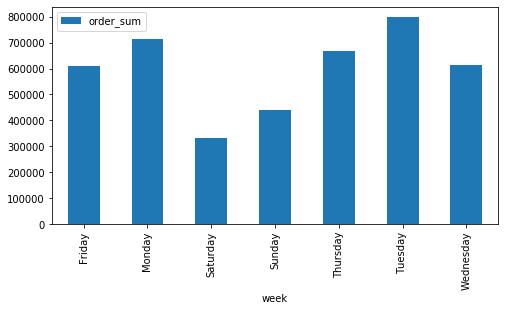

In [35]:
top_week.plot(y='order_sum', kind = 'bar',  figsize=(8, 4));

In [36]:
top_hour = df_clean.groupby('hour')['order_sum'].sum().to_frame('order_sum')
top_hour

,order_sum
hour,
0,43592.0
1,25231.0
2,31550.0
3,12413.0
4,18937.0
5,26735.0
6,61306.0
7,167869.0
8,238600.0


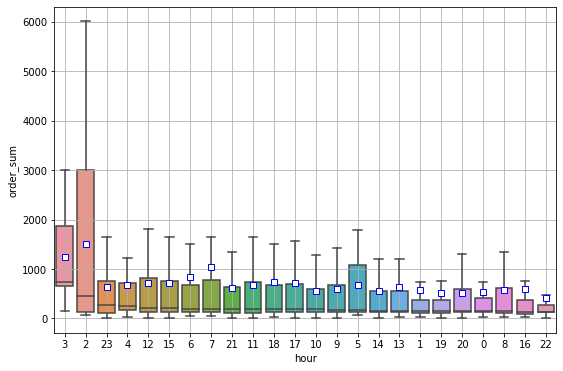

In [37]:
make_box_by_category(value='order_sum', category='hour', data=df_clean, sort=False, sort_by_column='order_sum', \
                     title='Распределение выручки по часам')

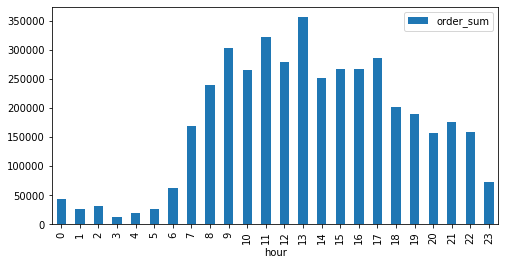

In [38]:
top_hour.plot(y='order_sum', kind = 'bar',  figsize=(8, 4));

В течении дня покупательская активность наблюдается с 9 до 17 часов, при этом максимальная активность в обеденное время в 13 часов.

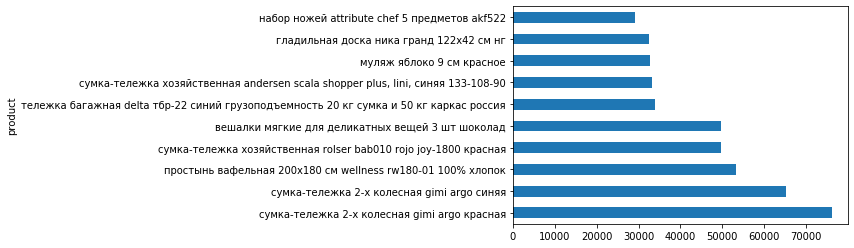

In [38]:
top_order_quantity = df_clean.pivot_table(index='product', aggfunc={'quantity':'sum','order_sum':'sum'})
top_order=top_order_quantity['order_sum'].sort_values(ascending=False).head(10)
top_order.plot(kind='barh');

Максимальная выручка наблюдается от товаров хозяйственного направления, а именно: сумки на колесиках, вешалки, домашний текстиль

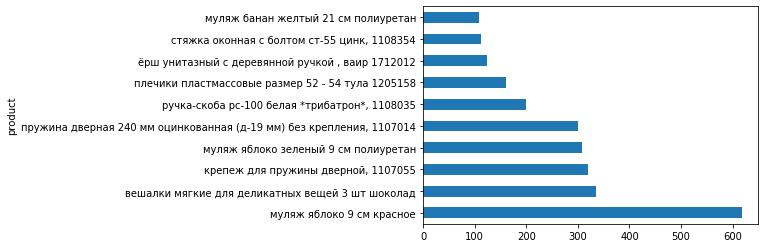

In [40]:
top_quantity=top_order_quantity['quantity'].sort_values(ascending=False).head(10)
top_quantity.plot(kind='barh');

В количественном выражении особой популярностью пользуются бытовые мелочи и декор

##### Рассмотрим ближе категории

In [39]:
plant=df_clean.query('category == "растения"')
housegoods=df_clean.query('category == "хозтовары"')
trifle=df_clean.query('category == "1001 мелочь"')
dishes=df_clean.query('category == "посуда"')
decor=df_clean.query('category == "декор"')
textile=df_clean.query('category == "текстиль"')
construction=df_clean.query('category == "строительство-ремонт"')
tehnic=df_clean.query('category == "техника-инструменты"')
chemistry=df_clean.query('category == "бытовая химия"')

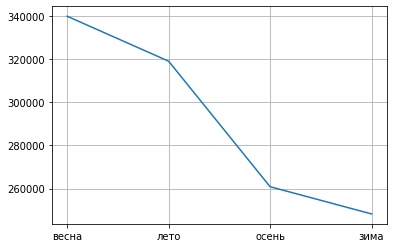

In [40]:
plant1 = plant.groupby('season')['order_sum'].sum().to_frame('order_sum').sort_values(by='order_sum', ascending=False)
plt.plot(plant1)
plt.xlim=10
plt.title ="Выручка по сезонам"
plt.grid()
plt.show()

В категории растения пик спроса приходится на весну, с последующим убыванием к зиме

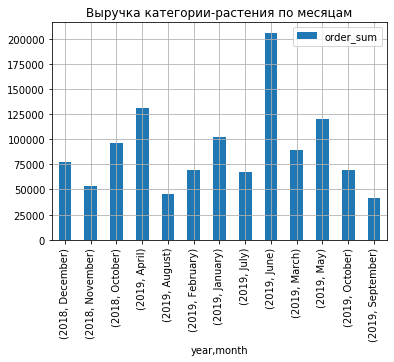

In [41]:
plant2 = plant.groupby(['year','month'])['order_sum'].agg({'order_sum':'sum'})
plant2.plot(kind='bar', title='Выручка категории-растения по месяцам')
plt.grid()
plt.show()

Всплеск в июне вероятнее всего из-за высокого спроса на рассаду

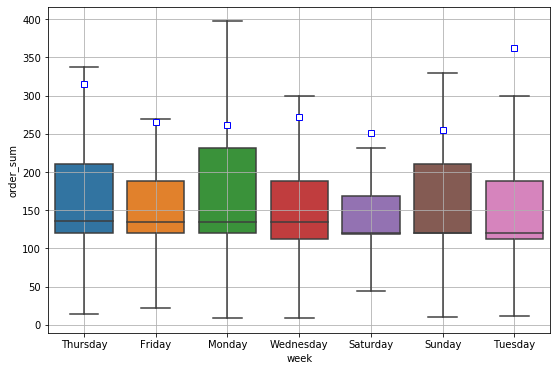

In [42]:
make_box_by_category(value='order_sum', category='week', data=plant, sort=False, sort_by_column='order_sum', \
                     title='Распределение выручки по часам')

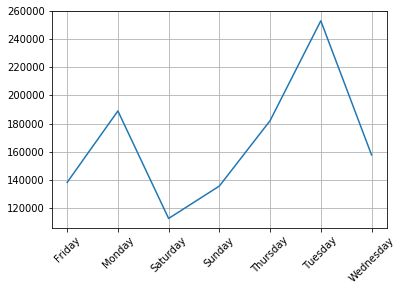

In [43]:
plant3 = plant.groupby('week')['order_sum'].sum().to_frame('order_sum')
plt.figsize=(20, 8)
plt.plot(plant3)
plt.xticks(rotation=45)
plt.grid()
plt.show()

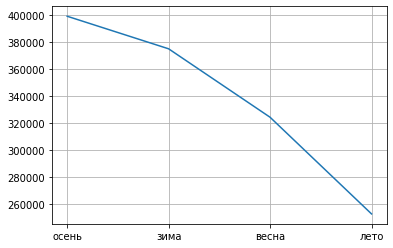

In [44]:
housegoods1=housegoods.groupby('season')['order_sum'].sum().to_frame('order_sum').sort_values(by='order_sum', ascending=False)
plt.plot(housegoods1)
plt.xlim=10
plt.grid()
plt.show()

У хозяйственных товаров максимальный спрос осенью, летом покупателей больше интересует озеленение

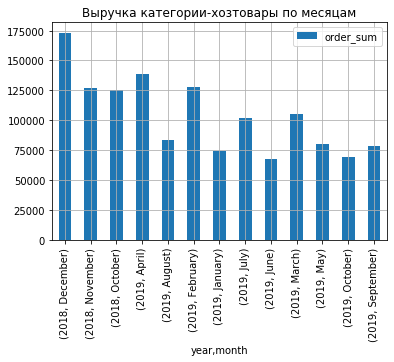

In [45]:
housegoods2 = housegoods.groupby(['year','month'])['order_sum'].agg({'order_sum':'sum'})
housegoods2.plot(kind='bar', title='Выручка категории-хозтовары по месяцам')
plt.grid()
plt.show()

Декабрь-пик продаж, видимо все хотят укомплектовать свои квартиры к новому году

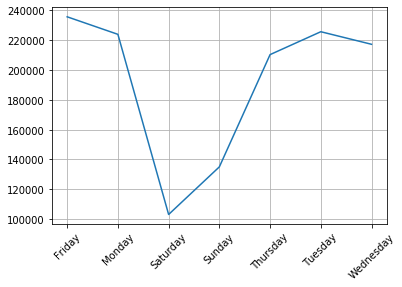

In [46]:
housegoods3 = housegoods.groupby('week')['order_sum'].sum().to_frame('order_sum')
plt.figsize=(20, 8)
plt.plot(housegoods3)
plt.xticks(rotation=45)
plt.grid()
plt.show()

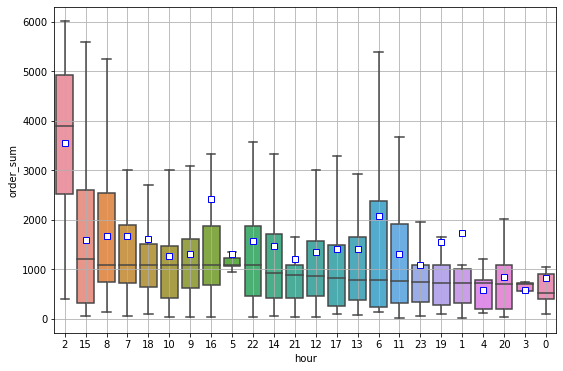

In [47]:
make_box_by_category(value='order_sum', category='hour', data=housegoods, sort=False, sort_by_column='order_sum', \
                     title='Распределение выручки по часам')

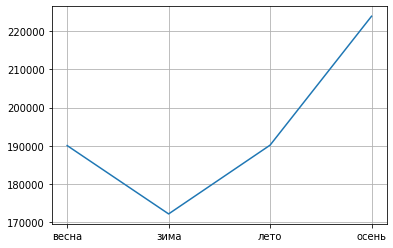

In [48]:
trifle1=trifle.groupby('season')['order_sum'].sum().to_frame('order_sum')
plt.plot(trifle1)
plt.xlim=10
plt.grid()
plt.show()

Что касается бытовых мелочей-пик популярности приходится на осень

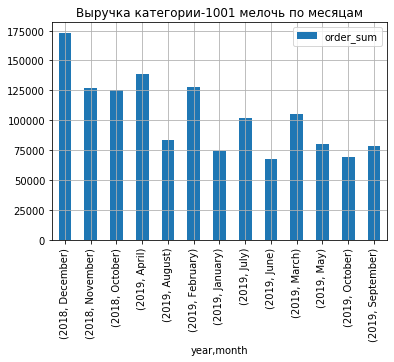

In [49]:
trifle2 = housegoods.groupby(['year','month'])['order_sum'].agg({'order_sum':'sum'})
trifle2.plot(kind='bar', title='Выручка категории-1001 мелочь по месяцам')
plt.grid()
plt.show()

Особенно популярна данная категория товаров в декабре

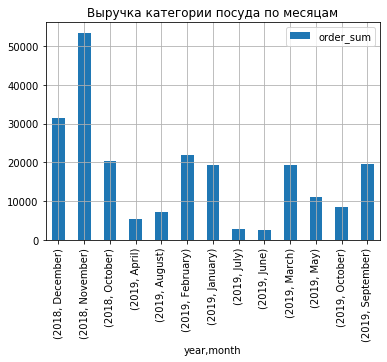

In [56]:
dishes1 = dishes.groupby(['year','month'])['order_sum'].agg({'order_sum':'sum'})
dishes1.plot(kind='bar', title='Выручка категории посуда по месяцам')
plt.grid()
plt.show()

Посуда хоть и не так популярна как предыдущая группа товаров, но тоже имеет определенный всплеск в ноябре-декабре. Подготовка к рождеству и новому году

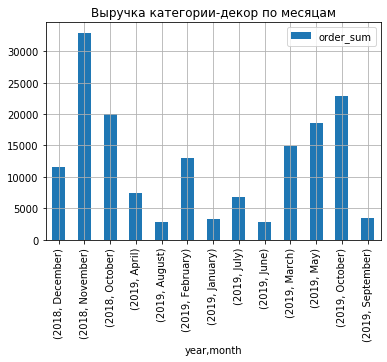

In [51]:
decor1=decor.groupby(['year','month'])['order_sum'].agg({'order_sum':'sum'})
decor1.plot(kind='bar', title='Выручка категории-декор по месяцам')
plt.grid()
plt.show()

Декор особенно популярен в октябре-ноябре, и практически неинтересен летом

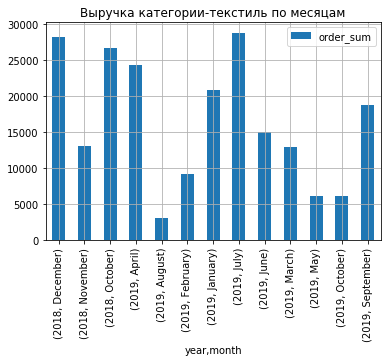

In [57]:
textile1=textile.groupby(['year','month'])['order_sum'].agg({'order_sum':'sum'})
textile1.plot(kind='bar', title='Выручка категории-текстиль по месяцам')
plt.grid()
plt.show()

В октябре 2019 года замечен провал в выручке текстиля, для выяснения данного феномена необходимы доп сведения

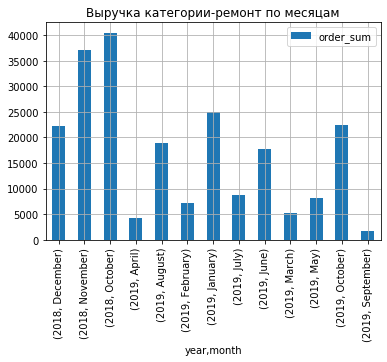

In [58]:
construction1=construction.groupby(['year','month'])['order_sum'].agg({'order_sum':'sum'})
construction1.plot(kind='bar', title='Выручка категории-ремонт по месяцам')
plt.grid()
plt.show()

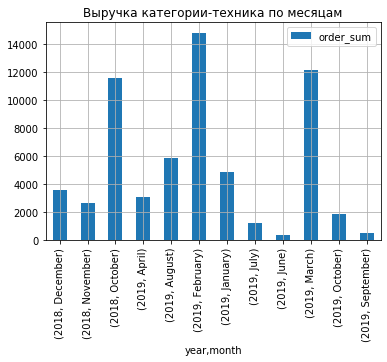

In [59]:
tehnic1=tehnic.groupby(['year','month'])['order_sum'].agg({'order_sum':'sum'})
tehnic1.plot(kind='bar', title='Выручка категории-техника по месяцам')
plt.grid()
plt.show()

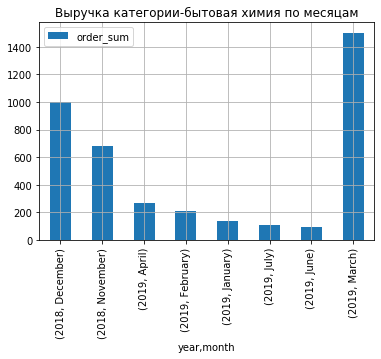

In [60]:
chemistry1=chemistry.groupby(['year','month'])['order_sum'].agg({'order_sum':'sum'})
chemistry1.plot(kind='bar', title='Выручка категории-бытовая химия по месяцам')
plt.grid()
plt.show()

#### Гипотезы

In [61]:
# выделим группы
def weekday (row):
    weekday = row['week']
    if weekday == 'Saturday' or weekday == 'Sunday' :
        return 'A'
      
    else:
        return 'B'

In [62]:
alpha = .05 # критический уровень статистической значимости

In [63]:
df_clean['group'] = df_clean.apply(weekday, axis=1)

In [64]:
df_clean = df_clean.drop_duplicates(subset=['customer_id'], keep=False)

In [65]:
ordersA=df_clean[df_clean['group'] == 'A']['order_sum']
ordersB=df_clean[df_clean['group'] == 'B']['order_sum']

Воспользуемся Критерием Уилкоксона-Манна-Уитни, используемый для оценки различий между двумя выборками по признаку, измеренному в количественной или порядковой шкале

In [66]:
result=st.mannwhitneyu(ordersA, ordersB)

In [67]:
print("ГИПОТЕЗА-По данным нет различий в суммарной выручке в выходные и в суммарной выручке в будние дни")
print('p-значение:', format(result[1]))

if (result[1] < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

ГИПОТЕЗА-По данным нет различий в суммарной выручке в выходные и в суммарной выручке в будние дни
p-значение: 0.35139243587773505
Не получилось отвергнуть нулевую гипотезу


In [68]:
print("относительные различия  в суммарной выручке в выходные и в суммарной выручке в будние дни", \
      format((ordersB.mean()/ordersA.mean())-1))

относительные различия  в суммарной выручке в выходные и в суммарной выручке в будние дни 0.18468841572187245


Суммарная выручка в будние дни превышает суммарную выручку в выходные дни на 18%. 

# Вывод

Исходя из проведенного анализа можно выработать следующие рекомендации:
- Выявленная сезонность продажи отдельных видов товаров дает возможность увеличить в этот момент их ассортимент, а также проработать систему продажи сопутствующих товаров. То есть максимально использовать сезонный покупательский спрос.
- По прошествии сезона низкой покупательской активности(летние отпуска, рождественские каникулы и т д) необходимо обратить внимание на отложенный покупательский спрос на товары с постоянным стабильным спросом.
- Для увеличения продаж выходного дня необходимо сделать акцент на акции "выходного дня", начисление двойных бонусов и иные мотивирующие предложения.
- По истечении суточной активности также необходимо использовать мотивирующие промоакции, чтобы побудить покупателей совершать сделки в вечернее время
- Увеличению продаж может способствовать разработка удобного мобильного приложения, так как дневная активность связана с использованием десктопов на рабочем месте.

Была выдвинута гипотеза о равенстве суммарной выручки в будние дни и суммарной выручкм в выходные. Данная гипотеза не подтвердилась, в абсолютном показателе выручка выходного дня на 18% меньше выручки в будние дни.

# Материалы
https://drive.google.com/file/d/1m_pBRtPGQL-h7KApZ2JBmccD5cAjDNxM/view?usp=sharing